# Capstone Project - The Battle of the Neighborhoods (Notebook)
### Applied Data Science Capstone by IBM

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
    * [Data Importing and Cleaning](#data_cleaning)
    * [Exploratory Data Analysis](#exploratory_data)
    * [Statistical Testing](#statistical_testing)
    * [Machine Learning - Clustering](#clustering)
* [Analysis](#analysis)
* [Results](#result)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

New York City is one of the most densely populated major city in United States. Also, it has been described as the cultural, financial, and media capital of the world. Based on these features, not only people around the world would like to visit NYC, many of them even move to NYC to experience this one of the most diverse city in the world. Thus, different kinds of cuisines are needed in NYC to satisfy different people in NYC. As a result, this report tends to help a group of investors who are planning to open their first Poke Bowl restaurant in NYC.
With the limited knowledge of NYC market, the investors hope this report help finding the best location to launch their first restaurant in NYC. Below are the most concerned factors by the group when choosing the best location to start their business. Population in each boroughs and neighborhoods was not considered in this analysis because NYC is a very convenient city. People can travel to each boroughs and neighborhoods easily by subway; therefore, populations does not have much impact in the analysis.
* Crime rate 
* Infrastructure
* Traffic

## Data <a name="data"></a>

* ***Neighborhood Names GIS*** <br/>
This is a dataset from NYC Open Data, which is formed by the Mayor’s Office of Data Analytics (MODA) and the Department of Information Technology and Telecommunications (DoITT). This dataset includes neighborhood labels as depicted in New York City. <br/>
* ***NYPD Complaint Data Current (Year To Date)*** <br/>
This is a dataset from NYC Open Data, which is formed by the MODA and DoITT. This dataset includes all valid felony, misdemeanour, and violation crimes reported to the New York City Police Department (NYPD) for all complete quarters so far in 2019. <br/>
* ***Foursquare API*** <br/>
Foursquare is a trusted and independent location data platform for understanding how people move through the real world. It will be used to collect data on other venues in the neighborhoods of New York City.


## Methodology <a name="methodology"></a>

### Importing Dataset & Data Cleansing  <a name="data_cleaning"></a>

In [1]:
# Importing libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

#### Downloading Neighborhood Names GIS dataset from NYC OpenData

Below is the data dictionary of Neighborhood Names GIS dataset. </br>
Since not all the columns are needed for analysis, will remove some columns.

Column Name      | Column Descriptions
-------------    | -------------
The_geom         | The geometry data of the neighborhood
Object ID        | The object ID of each neighborhood
Name             | The name of the neighborhood
Borough          | The name of the borough

In [2]:
import urllib.request, json
with urllib.request.urlopen("https://data.cityofnewyork.us/api/geospatial/99bc-9p23?method=export&format=GeoJSON") as url:
    data = json.loads(url.read().decode())

neighborhood_names_GIS = data['features']

In [3]:
# Creating column names
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
NYC_neighborhoods = pd.DataFrame(columns = column_names)

In [4]:
# Loading data to pandas dataframe
for data in neighborhood_names_GIS:
    borough = data['properties']['borough']
    Neighborhood_name = data['properties']['name']

    Neighborhood_latlon = data['geometry']['coordinates']
    Neighborhood_lat = Neighborhood_latlon[1]
    Neighborhood_lon = Neighborhood_latlon[0]

    NYC_neighborhoods = NYC_neighborhoods.append({'Borough': borough,
                                                    'Neighborhood': Neighborhood_name,
                                                    'Latitude': Neighborhood_lat,
                                                    'Longitude': Neighborhood_lon}, ignore_index=True)

NYC_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
print('The dataframe has {} boroughs and {} neighborhoods'.format(
    len(NYC_neighborhoods['Borough'].unique()),
    NYC_neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 299 neighborhoods


##### Creating a map of NYC with neighborhoods indicator 

In [6]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# Creating map of NYC with latitude and longitude
NYC_map = folium.Map(location=[latitude, longitude], zoom_start = 10)

# Adding markers to the map
for lat, lng, borough, neighborhood in zip( NYC_neighborhoods['Latitude'], NYC_neighborhoods['Longitude'], NYC_neighborhoods['Borough'], NYC_neighborhoods['Neighborhood']):
    label = '{}', '{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#3186cc',
        fill_opcity = 0.7,
        parse_html=True).add_to(NYC_map)
NYC_map

#### Downloading NYPD Complaint Data Current (Year To Date) dataset from NYC OpenData

Below is the data dictionary of NYPD Complaint Data Current (Year To Date) dataset. </br>
Since not all the columns are needed for analysis, will remove some columns.

Column Name      | Column Description
-------------    | -------------
CMPLNT_NUM       |     Randomly generated persistent ID for each complaint 
ADDR_PCT_CD      |     The precinct in which the incident occurred
BORO             |     The name of the borough in which the incident occurred
CMPLNT_FR_DT     |     Exact date of occurrence for the reported event (or starting date of occurrence, if CMPLNT_TO_DT exists)
CMPLNT_FR_TM     |     Exact time of occurrence for the reported event (or starting time of occurrence, if CMPLNT_TO_TM exists)
CMPLNT_TO_DT     |     Ending date of occurrence for the reported event, if exact time of occurrence is unknown
CMPLNT_TO_TM     |     Ending time of occurrence for the reported event, if exact time of occurrence is unknown
CRM_ATPT_CPTD_CD     |     Indicator of whether crime was successfully completed or attempted, but failed or was interrupted prematurely
HADEVELOPT     |     Name of NYCHA housing development of occurrence, if applicable
HOUSING_PSA     |     Development Level Code
JURISDICTION_CODE     |     Jurisdiction responsible for incident. Either internal, like Police(0), Transit(1), and Housing(2); or external(3), like Correction, Port Authority, etc.
JURIS_DESC     |     Description of the jurisdiction code
KY_CD     |     Three digit offense classification code
LAW_CAT_CD     |     Level of offense: felony, misdemeanor, violation 
LOC_OF_OCCUR_DESC     |     Specific location of occurrence in or around the premises; inside, opposite of, front of, rear of
OFNS_DESC     |     Description of offense corresponding with key code
PARKS_NM     |     Name of NYC park, playground or greenspace of occurrence, if applicable (state parks are not included)
PATROL_BORO     |     The name of the patrol borough in which the incident occurred
PD_CD     |     Three digit internal classification code (more granular than Key Code)
PD_DESC     |     Description of internal classification corresponding with PD code (more granular than Offense Description)
PREM_TYP_DESC     |     Specific description of premises; grocery store, residence, street, etc.
RPT_DT     |     Date event was reported to police 
STATION_NAME     |     Transit station name
SUSP_AGE_GROUP     |     Suspect’s Age Group
SUSP_RACE     |     Suspect’s Race Description
SUSP_SEX     |     Suspect’s Sex Description
TRANSIT_DISTRICT     |     Transit district in which the offense occurred.
VIC_AGE_GROUP     |     Victim’s Age Group
VIC_RACE     |     Victim’s Race Description
VIC_SEX     |     Victim’s Sex Description
X_COORD_CD     |     X-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104)
Y_COORD_CD     |     Y-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104)
Latitude     |     Midblock Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326) 
Longitude     |     Midblock Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)


In [7]:
import urllib.request, json
with urllib.request.urlopen("https://data.cityofnewyork.us/resource/5uac-w243.geojson") as url:
    data = json.loads(url.read().decode())

NYPD_complaint_data = data['features']

In [8]:
column_names = ['CMPLNT_NUM', 'BORO_NM', 'CMPLNT_FR_DT', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'OFNS_DESC', 'PREM_TYP_DESC', 'Latitude', 'Longitude']
NYPD_complaint = pd.DataFrame(columns = column_names)

In [9]:
for data in NYPD_complaint_data:
    complaint_num = data ['properties']['cmplnt_num']
    borough = data['properties']['boro_nm']
    complaint_date = data['properties']['cmplnt_fr_dt']
    attempt_indicator = data['properties']['crm_atpt_cptd_cd']
    law_cat_cd = data['properties']['law_cat_cd']
    ofns_desc = data['properties']['ofns_desc']
    prem_tpy_desc = data['properties']['prem_typ_desc']

    complaint_latlon = data['geometry']['coordinates']
    complaint_lat = complaint_latlon[1]
    complaint_lon = complaint_latlon[0]
    
    NYPD_complaint = NYPD_complaint.append({'CMPLNT_NUM': complaint_num,
                                            'BORO_NM': borough,
                                            'CMPLNT_FR_DT': complaint_date,
                                            'CRM_ATPT_CPTD_CD': attempt_indicator,
                                            'LAW_CAT_CD': law_cat_cd,
                                            'OFNS_DESC': ofns_desc,
                                            'PREM_TYP_DESC': prem_tpy_desc,
                                            'Latitude': complaint_lat,
                                            'Longitude': complaint_lon}, ignore_index=True)

In [10]:
# Changing the data type of COMPLNT_FR_DT to DateTime
NYPD_complaint.CMPLNT_FR_DT = pd.to_datetime(NYPD_complaint.CMPLNT_FR_DT)


This dataset includes all kinds of crime data from 1918 to 2019 received by NYPD. </br>However, most of the data is irrelevant or outdated to the analysis. </br>
Therefore, only crime data in 2019 will be taken into consideration in this analysis.

In [11]:
# Filtering out the irrelavent data
start_date = "2019-01-01"
end_date = "2019-12-31"
NYPD_complaint = NYPD_complaint.loc[(NYPD_complaint['CMPLNT_FR_DT'] >= start_date) & (NYPD_complaint['CMPLNT_FR_DT'] <= end_date)]
NYPD_complaint.sort_values('CMPLNT_FR_DT').head()

,CMPLNT_NUM,BORO_NM,CMPLNT_FR_DT,CRM_ATPT_CPTD_CD,LAW_CAT_CD,OFNS_DESC,PREM_TYP_DESC,Latitude,Longitude
416,363730032,BROOKLYN,2019-01-01,COMPLETED,MISDEMEANOR,CRIMINAL MISCHIEF & RELATED OF,OTHER,40.640322,-73.943135
464,990832898,BRONX,2019-01-01,COMPLETED,MISDEMEANOR,SEX CRIMES,RESIDENCE-HOUSE,40.843901,-73.900505
599,642568483,QUEENS,2019-02-01,COMPLETED,MISDEMEANOR,PETIT LARCENY,STREET,40.681293,-73.766448
273,889511893,QUEENS,2019-02-01,COMPLETED,MISDEMEANOR,SEX CRIMES,RESIDENCE-HOUSE,40.602952,-73.749976
256,787952040,BRONX,2019-02-22,COMPLETED,MISDEMEANOR,OFFENSES INVOLVING FRAUD,STREET,40.814377,-73.907684


#### Define Foursquare Credentials and Version and Exploring the Neighborhoods

In [12]:
#### Define Foursquare Credentials and Version and Exploring the Neighborhoods
CLIENT_ID = 'HYVWEMYA1JNQYQL4Y0YTGGBT0EI2XBKMRN0X3QG5U10UFIRY' # my Foursquare ID
CLIENT_SECRET = 'JUGI5OBZALF51MI5NUQDY0PCZO3MFUTOMAZIWROAMAJE5XM1' # my Foursquare Secret
VERSION = '20190126' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HYVWEMYA1JNQYQL4Y0YTGGBT0EI2XBKMRN0X3QG5U10UFIRY
CLIENT_SECRET:JUGI5OBZALF51MI5NUQDY0PCZO3MFUTOMAZIWROAMAJE5XM1


#### Getting the top venues in each neighborhood in NYC

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Neighborhood Latitude',
                  'Neighborhood Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category']

    return(nearby_venues)

In [14]:
# Getting a new dataframe for NYC venues
NYC_venues = getNearbyVenues(names = NYC_neighborhoods['Neighborhood'],
                                   latitudes = NYC_neighborhoods['Latitude'],
                                   longitudes = NYC_neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [15]:
# Checking the size of the resulting dataframe
print(NYC_venues.shape)
NYC_venues.head()

(10055, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station
4,Wakefield,40.894705,-73.847201,SUBWAY,40.890468,-73.849152,Sandwich Place


In [16]:
# Checking how many venues were returned for each neighborhood
NYC_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Annadale,10,10,10,10,10,10
Arden Heights,5,5,5,5,5,5
Arlington,5,5,5,5,5,5
Arrochar,18,18,18,18,18,18
Arverne,18,18,18,18,18,18


In [17]:
print('There are {} uniques categories.'.format(len(NYC_venues['Venue Category'].unique())))

There are 422 uniques categories.


### Exploratory Data Anaysis<a name="exploratory_data"></a>

#### 1.) Exploratory Data Analysis on NYPD Complaint Data Current (Year To Date) dataset

In [18]:
# Importing matplotlib for data visualization
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

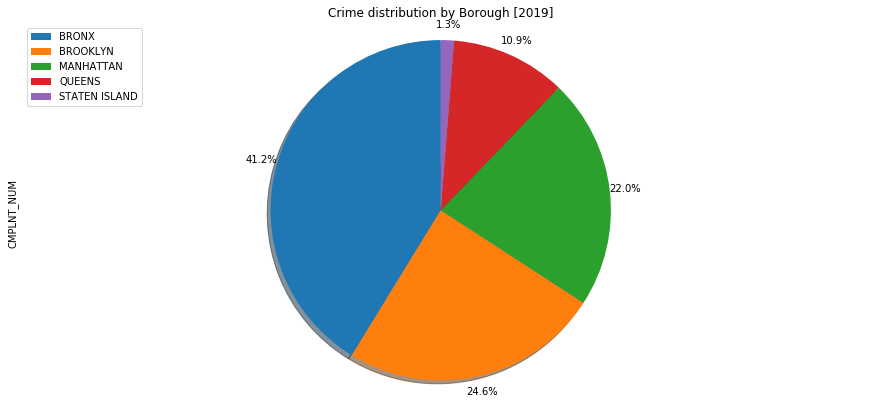

In [19]:
# Crime distribution by Borough [2019]
df_crime_borough = pd.DataFrame(NYPD_complaint.groupby('BORO_NM').count()[['CMPLNT_NUM']])
df_crime_borough

df_crime_borough['CMPLNT_NUM'].plot(kind = 'pie',
                                    figsize = (15, 7), 
                                    autopct= '%1.1f%%',
                                    startangle = 90,
                                    shadow = True,
                                    labels = None,
                                    pctdistance=1.093
                                    )
                                    
plt.title('Crime distribution by Borough [2019]')
plt.axis('equal')
plt.legend(labels = df_crime_borough.index, loc = 'upper left')

plt.show()

In [20]:
# Map with crime markers
NYC_map_marker = folium.Map(location=[latitude, longitude], zoom_start = 10)

from folium import plugins

incidents = plugins.MarkerCluster().add_to(NYC_map_marker)

for lat, lng, label in zip (NYPD_complaint.Latitude, NYPD_complaint.Longitude, NYPD_complaint.OFNS_DESC):
    folium.Marker(
        location=[lat, lng],
        icon = None,
        popup = label,
    ).add_to(incidents)
    
NYC_map_marker

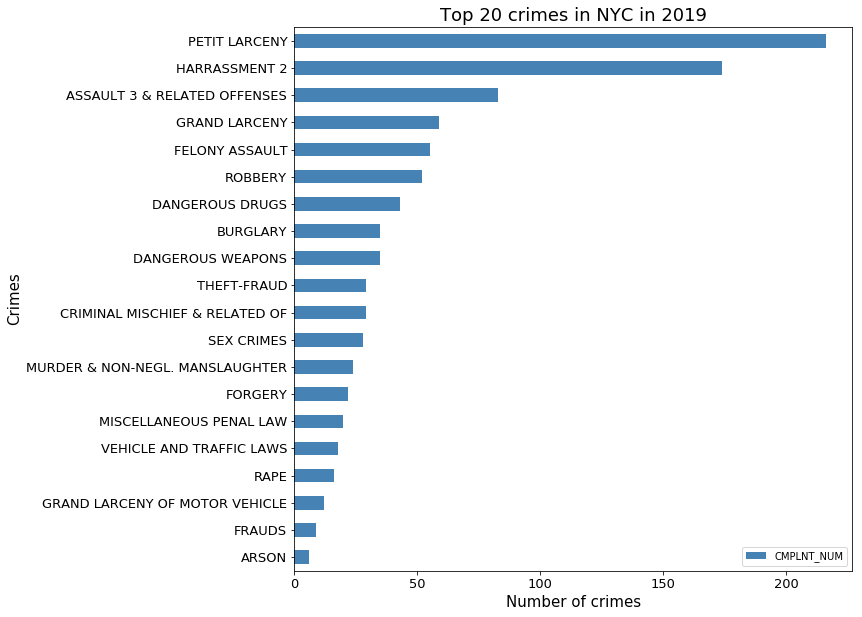

In [21]:
# Top 20 Offensive Description
df_top_20_crime = pd.DataFrame(NYPD_complaint.groupby('OFNS_DESC').count()[['CMPLNT_NUM']])
df_top_20_crime = df_top_20_crime.sort_values('CMPLNT_NUM', ascending=False).head(20)

ax = df_top_20_crime.plot(kind = 'barh',
                    figsize = (10,10),
                    color = 'steelblue',
                    fontsize = 13);

ax.set_alpha(0.8)
ax.set_title('Top 20 crimes in NYC in 2019', fontsize = 18)
ax.set_xlabel('Number of crimes', fontsize = 15)
ax.set_ylabel('Crimes', fontsize = 15)
ax.invert_yaxis()

plt.show()

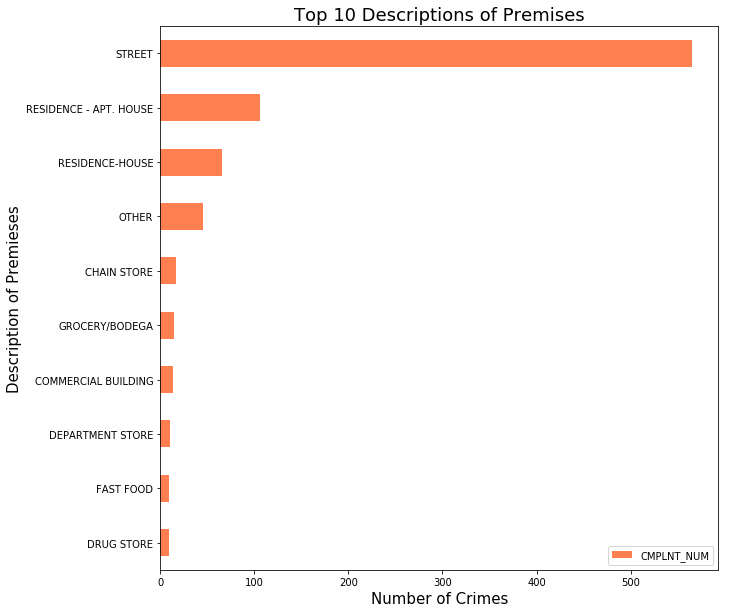

In [22]:
# Top 10 Descrptions of Premieses
df_top_10_premieses = pd.DataFrame(NYPD_complaint.groupby('PREM_TYP_DESC').count()[['CMPLNT_NUM']])
df_top_10_premieses = df_top_10_premieses.sort_values('CMPLNT_NUM', ascending=False).head(10)
df_top_10_premieses

ax_1 = df_top_10_premieses.plot(kind = 'barh',
                        figsize = (10,10),
                        color = 'coral')

ax_1.set_alpha(0.8)
ax_1.set_title('Top 10 Descriptions of Premises', fontsize = 18)
ax_1.set_xlabel('Number of Crimes', fontsize = 15)
ax_1.set_ylabel('Description of Premieses', fontsize = 15)
ax_1.invert_yaxis()

plt.show()

#### 2.) Exploratory Data Analysis on NYC Neighborhoods

In [23]:
# one hot encoding
NYC_onehot = pd.get_dummies(NYC_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NYC_onehot[['Neighborhood']] = NYC_venues[['Neighborhood']] 

# move neighborhood column to the first column
fixed_columns = [NYC_onehot.columns[-1]] + list(NYC_onehot.columns[:-1])
NYC_onehot = NYC_onehot[fixed_columns]

NYC_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,

In [24]:
# Grouping rows by neighborhood and taking the mean of frequency of occurrence of each category
NYC_grouped = NYC_onehot.groupby('Neighborhood').mean().reset_index()
NYC_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,

In [25]:
# Finding the top 10 most common venues in each neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NYC_grouped['Neighborhood']

for ind in np.arange(NYC_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NYC_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Annadale,Bakery,Pizza Place,American Restaurant,Diner,Train Station,Restaurant,Pharmacy,Sports Bar,Event Service,Ethiopian Restaurant
1,Arden Heights,Pharmacy,Deli / Bodega,Bus Stop,Coffee Shop,Pizza Place,Women's Store,Fast Food Restaurant,Ethiopian Restaurant,Event Service,Event Space
2,Arlington,Bus Stop,Grocery Store,Deli / Bodega,Boat or Ferry,Women's Store,Filipino Restaurant,Event Service,Event Space,Exhibit,Factory
3,Arrochar,Italian Restaurant,Bus Stop,Deli / Bodega,Middle Eastern Restaurant,Athletics & Sports,Pizza Place,Bagel Shop,Outdoors & Recreation,Supermarket,Polish Restaurant
4,Arverne,Surf Spot,Sandwich Place,Metro Station,Board Shop,Wine Shop,Thai Restaurant,Beach,Coffee Shop,Bed & Breakfast,Bus Stop


### Statistical Analysis <a name="statistical_testing"></a>

In [27]:
from sklearn import metrics
from scipy.spatial.distance import cdist

NYC_grouped_clustering = NYC_grouped.drop('Neighborhood', 1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(NYC_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

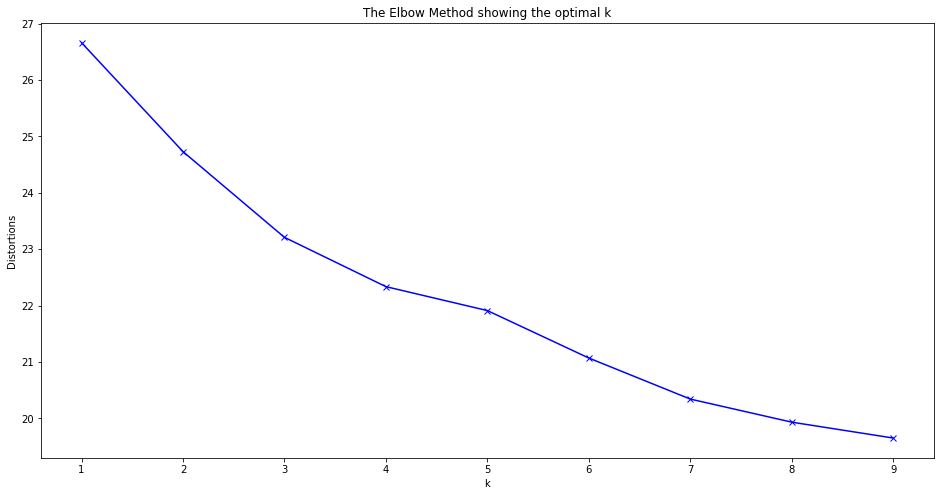

In [28]:
# Plotting the distortions of K-Means
plt.figure(figsize = (16, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Clustering the Neighborhoods <a name="clustering"></a>

In [29]:
### Clustering the Neighborhoods 
kclusters = 5 # set number of clusters
NYC_grouped_clustering = NYC_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NYC_grouped_clustering) # run k-means clustering
kmeans.labels_[0:100] 

array([3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 0, 3, 3, 0, 3, 3, 3, 2, 3, 1, 2, 3, 3, 0, 2, 2, 3, 3, 2, 3,
       3, 3, 3, 3, 3, 2, 3, 2, 4, 3, 3, 3, 2, 3, 3, 0, 2, 2, 2, 3, 3, 2,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 0, 3, 3,
       3, 2, 2, 3, 2, 3, 2, 2, 3, 3, 3, 3], dtype=int32)

In [31]:
# Creating a new dataframe with the cluster number and top 10 venues in each neighborood

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
NYC_merged = NYC_neighborhoods

NYC_merged = NYC_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
NYC_merged['Cluster Labels'] = NYC_merged['Cluster Labels'].fillna(0).astype(np.int64)

NYC_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,2,Pharmacy,Ice Cream Shop,Gas Station,Dessert Shop,Donut Shop,Sandwich Place,Laundromat,Caribbean Restaurant,Event Space,Factory
1,Bronx,Co-op City,40.874294,-73.829939,2,Bus Station,Mattress Store,Restaurant,Fast Food Restaurant,Discount Store,Bagel Shop,Gift Shop,Salon / Barbershop,Fried Chicken Joint,Pharmacy
2,Bronx,Eastchester,40.887556,-73.827806,2,Caribbean Restaurant,Diner,Deli / Bodega,Bus Station,Bowling Alley,Donut Shop,Seafood Restaurant,Chinese Restaurant,Pizza Place,Platform
3,Bronx,Fieldston,40.895437,-73.905643,2,Music Venue,River,Bus Station,Plaza,Field,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
4,Bronx,Riverdale,40.890834,-73.912585,2,Park,Bank,Plaza,Moving Target,Bus Station,Gym,Home Service,Food Truck,Design Studio,Dessert Shop


#### Cluster 1

In [32]:
#### CLuster 1
NYC_merged.loc[NYC_merged['Cluster Labels'] == 0].head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
77,Brooklyn,Manhattan Beach,40.577914,-73.943537,0,Bus Stop,Playground,Ice Cream Shop,Café,Sandwich Place,Pizza Place,Beach,Food,Event Space,Event Service
174,Queens,Breezy Point,40.557401,-73.925512,0,Trail,Beach,Bus Stop,Monument / Landmark,Women's Store,Field,Ethiopian Restaurant,Event Service,Event Space,Exhibit
181,Queens,Neponsit,40.572037,-73.857547,0,Beach,Women's Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm
200,Staten Island,New Brighton,40.640615,-74.087017,0,Bus Stop,Park,Deli / Bodega,Home Service,Playground,Discount Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit
204,Staten Island,Grymes Hill,40.624185,-74.087248,0,Moving Target,Bus Stop,Dog Run,Women's Store,Field,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory


#### Cluster 2

In [33]:
#### CLuster 2
NYC_merged.loc[NYC_merged['Cluster Labels'] == 1].head(20)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
195,Queens,Brookville,40.660003,-73.751753,1,Deli / Bodega,Women's Store,Field,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant


#### Cluster 3

In [34]:
#### CLuster 3
NYC_merged.loc[NYC_merged['Cluster Labels'] == 2].head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,2,Pharmacy,Ice Cream Shop,Gas Station,Dessert Shop,Donut Shop,Sandwich Place,Laundromat,Caribbean Restaurant,Event Space,Factory
1,Bronx,Co-op City,40.874294,-73.829939,2,Bus Station,Mattress Store,Restaurant,Fast Food Restaurant,Discount Store,Bagel Shop,Gift Shop,Salon / Barbershop,Fried Chicken Joint,Pharmacy
2,Bronx,Eastchester,40.887556,-73.827806,2,Caribbean Restaurant,Diner,Deli / Bodega,Bus Station,Bowling Alley,Donut Shop,Seafood Restaurant,Chinese Restaurant,Pizza Place,Platform
3,Bronx,Fieldston,40.895437,-73.905643,2,Music Venue,River,Bus Station,Plaza,Field,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
4,Bronx,Riverdale,40.890834,-73.912585,2,Park,Bank,Plaza,Moving Target,Bus Station,Gym,Home Service,Food Truck,Design Studio,Dessert Shop


#### Cluster 4

In [35]:
#### CLuster 4
NYC_merged.loc[NYC_merged['Cluster Labels'] == 3].head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Bronx,Kingsbridge,40.881687,-73.902818,3,Pizza Place,Sandwich Place,Bar,Latin American Restaurant,Supermarket,Deli / Bodega,Mexican Restaurant,Spanish Restaurant,Pharmacy,Donut Shop
6,Manhattan,Marble Hill,40.876551,-73.910660,3,Sandwich Place,Coffee Shop,Yoga Studio,Kids Store,Shopping Mall,Gym,Seafood Restaurant,Bank,Miscellaneous Shop,Donut Shop
7,Bronx,Woodlawn,40.898273,-73.867315,3,Pub,Deli / Bodega,Pizza Place,Playground,Italian Restaurant,Train Station,Indian Restaurant,Food Truck,Moving Target,Food & Drink Shop
11,Bronx,Pelham Parkway,40.857413,-73.854756,3,Italian Restaurant,Pizza Place,Chinese Restaurant,Donut Shop,Coffee Shop,Liquor Store,Bank,Performing Arts Venue,Thai Restaurant,Gift Shop
12,Bronx,City Island,40.847247,-73.786488,3,Harbor / Marina,Seafood Restaurant,Thrift / Vintage Store,Italian Restaurant,History Museum,Music Venue,French Restaurant,Café,Smoke Shop,Boat or Ferry


#### Cluster 5

In [36]:
#### CLuster 5
NYC_merged.loc[NYC_merged['Cluster Labels'] == 4].head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Bronx,Clason Point,40.806551,-73.854144,4,Park,Grocery Store,Boat or Ferry,Pool,Bus Stop,South American Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Event Service,Event Space
194,Queens,Somerville,40.597711,-73.796648,4,Park,Women's Store,Fountain,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant
205,Staten Island,Todt Hill,40.597069,-74.111329,4,Park,Women's Store,Fountain,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant


### Result

In [37]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NYC_merged['Latitude'], NYC_merged['Longitude'], NYC_merged['Neighborhood'], NYC_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters